<a href="https://colab.research.google.com/github/MansMeg/IntroML/blob/master/assignments/swedish_bert_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of motions from the Swedish Parliament (Riksdagen) using a Swedish BERT model

Here we demonstrate how to perform document classification using models from the `transformers` Python library. We will be using a dataset consisting of parliamentary motions from the Swedish Parliament (Riksdagen). Can we predict which party authored a parliamentary motion using only the text of a motion as input? 

Huggingface `transformers` library has many high level abstractions for making training of large language models "simpler". In particular there is the `Trainer` class for launching training, and the `datasets` library for loading and working with Huggingface datasets. There are already [plenty](https://huggingface.co/course/chapter3/3?fw=pt) of guides on the internet showing [how to use these tools](https://huggingface.co/transformers/v3.2.0/custom_datasets.html#fine-tuning-with-trainer). 

While these high level abstractions might help make tutorials more succinct and straight to the point, it usually comes at the cost of creating barriers for students and practicians who at some later point may need to adapt their use to custom datasets and (non-standard) training objectives.

The patterns used in this guide will therefore all be standard Pytorch abstractions for creating datasets, dataloaders and writing your own custom training loops for transformer model trained for Swedish. These patterns are general for Pytorch, and thus applicable in almost all situations where you're working with Pytorch models. Your capacity to customize and change things is only limited by your knowledge of Pytorch and your basic coding abilities. 

## Setting up data

### Installing the `transformers` library

Google Colab doesn't have `transformers` preinstalled. Let's install it first.




In [29]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Downloading the Swedish parliamentary corpus

We download a dataset of parliamentary motions from the years 2014-2021 that has been collected from the Swedish parliament open data and prepared in advance. The interested reader can see where the data was [downloaded from](https://github.com/kb-labb/bertopic_workshop/blob/main/download_data.sh) and how it was [preprocessed](https://github.com/kb-labb/bertopic_workshop/blob/main/parse_motioner.py). 

In [30]:
!curl -L https://kungliga-biblioteket.box.com/shared/static/ii4yhmj0f5do0ifjtj1nzb13iy7dkq5e --output motioner_2014_2021.parquet

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     8    0     8    0     0      5      0 --:--:--  0:00:01 --:--:--     5
100 90.6M  100 90.6M    0     0  10.7M      0  0:00:08  0:00:08 --:--:-- 18.4M


We read our data file `motioner_2014_2021.parquet` as a dataframe and display a table of it below.

Here's a brief explanation of some column variables whose names may not be fully self-explanatory:

* **doc_id**: Unique id that identifies each parliamentary motion document.
* **text**: Contains the full body text of the parliamentary motion (truncated in the table below). 
* **datum**: Date.
* **dokument_html_url**: An URL to the document in html-format on Riksdagen's website.
* **titel**: Title.
* **subtitel**: Who wrote the motion ("m.fl." can be translated "et al."). 
* **organ**: Abbreviations of the different [committees ("utskott")](https://sv.wikipedia.org/wiki/Riksdagsutskott_(Sverige)) of the riksdag.  
* **subtyp**: Type of motion. Whether it was submitted by an individual member (Enskild motion), a committee (Kommittémotion), a political party (partimotion), or several parties (flerpartimotion). 
* **authors_\***: How many authors from each individual party that wrote the motion. 
* **nr_authors**: Total number of listed authors.
* **party**: Party abbreviations of party/parties involved in writing the motion, separated by commas.
* **single_party_authors**: Boolean variable indicating whether the authors of the motion were all from the same party (True), or whether it was a collaboration between several parties (False).

We use the `pandas` library to read in the corpus and display the five first motions. 

In [31]:
import pandas as pd
df = pd.read_parquet("motioner_2014_2021.parquet")
print(f"The dataset consists of a total of {len(df)} motions.")
df # Display only the 5 first rows of the dataframe

The dataset consists of a total of 29851 motions.


,dok_id,text,datum,dokument_url_html,titel,subtitel,organ,subtyp,hangar_id,authors_V,...,authors_MP,authors_C,authors_L,authors_KD,authors_M,authors_SD,authors_independent,nr_authors,party,single_party_authors
0,H9023691,Den svenska gruv- och mineralnäringen var med ...,2021-10-05,http://data.riksdagen.se/dokument/H9023691,En konkurrenskraftig gruvnäring för framtiden,av Lars Hjälmered m.fl. (M),NU,Kommittémotion,5109435,0,...,0,0,0,0,4,0,0,4,M,True
1,H6022337,Regeringen beslutade under 2017 att anta en na...,2018-11-29,http://data.riksdagen.se/dokument/H6022337,Starkare nationell cykelpolitik,av Emma Berginger (MP),TU,Enskild motion,5012022,0,...,1,0,0,0,0,0,0,1,MP,True
2,H8023930,Regeringen föreslår genom proposition 2020/21:...,2021-04-07,http://data.riksdagen.se/dokument/H8023930,med anledning av prop. 2020/21:159 Vissa ident...,av Christina Höj Larsen m.fl. (V),SfU,Kommittémotion,5092870,5,...,0,0,0,0,0,0,0,5,V,True
3,H80268,Under en sommarkväll 2018 misshandlades en per...,2020-09-11,http://data.riksdagen.se/dokument/H80268,Utvidgad nödvärnsrätt,av Markus Wiechel och Alexander Christiansson ...,JuU,Enskild motion,5066863,0,...,0,0,0,0,0,2,0,2,SD,True
4,H3021446,Företag skapar arbetstillfällen och bidrar til...,2015-10-05,http://data.riksdagen.se/dokument/H3021446,Företagsdag på högstadiet och gymnasiet,av Johan Nissinen (SD),UbU,Enskild motion,4386670,0,...,0,0,0,0,0,1,0,1,SD,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29846,H9021195,"Färjetrafiken till Gotland är öns landsväg, de...",2021-09-30,http://data.riksdagen.se/dokument/H9021195,Statligt ansvar för en reservhamn i Gotlandstr...,av Lars Thomsson (C),TU,Enskild motion,5106758,0,...,0,1,0,0,0,0,0,1,C,True
29847,H5023547,Länge har problemet just varit att Sverige int...,2017-10-05,http://data.riksdagen.se/dokument/H5023547,Visum och bidragssanktioner mot länder som int...,av Kent Ekeroth (SD),SfU,Enskild motion,4773394,0,...,0,0,0,0,0,1,0,1,SD,True
29848,H2021061,Inför riksdagsvalen går debattens vågor höga. ...,2014-11-07,http://data.riksdagen.se/dokument/H2021061,Förbättrad kvalitet i valdebatten,av Betty Malmberg (M),KU,Enskild motion,3111220,0,...,0,0,0,0,1,0,0,1,M,True
29849,H5023948,Riksrevisionen riktar mycket allvarlig kritik ...,2018-01-09,http://data.riksdagen.se/dokument/H5023948,med anledning av skr. 2017/18:68 Riksrevisione...,av Stefan Jakobsson och Robert Stenkvist (båda...,UbU,Enskild motion,4785744,0,...,0,0,0,0,0,2,0,2,SD,True


### Prepare the corpus

Before we can get started, we first need to 

1. create an integer label column we want to classify.
2. divide our data into a training and evaluation set.

A small proportion of parliamentary motions are also the result of several members of parliament collaborating across party lines. In this guide, we make it simple for ourselves and simply filter out the observations with multiple authors from different political parties. 

For now, we include only 'enskilda motioner' below.

Training can take upwards to 2-3 hours if we include all observations. For this reason we select a subset of the data spanning the last mandate period from 2018-10-01 and forwards.

In [32]:
df = df[df["datum"] >= "2018-10-01"].reset_index(drop=True)
df = df[df["single_party_authors"] == True].reset_index(drop=True)
df = df[df["subtyp"] == "Enskild motion"] # Filter to keep only enskilda motioner
label_mapping = {
    0: "V",
    1: "S",
    2: "MP",
    3: "C",
    4: "L",
    5: "M",
    6: "KD",
    7: "SD",
    8: "independent",
}
label_mapping = {v: k for k, v in label_mapping.items()} # Reverse key/value
df["label"] = df["party"].map(label_mapping)
df = df.reset_index(drop=True)

df_train = df.sample(frac=0.85, random_state=5)
df_valid = df.drop(df_train.index)

df_train[["dok_id", "text", "party", "label", "titel", "subtitel"]]

,dok_id,text,party,label,titel,subtitel
5177,H9021161,"För många av våra äldre tonåringar, inte minst...",KD,6,A-traktorer,av Kjell-Arne Ottosson (KD)
928,H8022931,Sverige har en mycket lång kust med öppna strä...,C,3,Marint skräp,av Fredrik Christensson och Rickard Nordin (bå...
833,H8021154,Det är angeläget att hela Sverige ska leva. Vi...,M,5,Ökad robusthet med fleråriga tågplaner,av Ann-Sofie Lifvenhage (M)
2681,H802752,Den fria och självständiga idrottsrörelsen är ...,S,1,Momsregler och civilsamhället,av Anna Wallentheim (S)
7683,H6021956,Sverigedemokraternas utgångspunkt är att tille...,SD,7,Sverigedemokraternas biståndspolitik,av Ludvig Aspling m.fl. (SD)
...,...,...,...,...,...,...
4346,H90279,"Kvinnor i Saudiarabien, Afghanistan och Iran d...",independent,8,Sanktioner mot bl.a. Iran och Saudiarabien,av Amineh Kakabaveh (-)
3280,H9021259,Utbyggnaden av barnomsorg i offentlig regi har...,S,1,Barnomsorg på de tider då föräldrarna arbetar,av Hillevi Larsson (S)
7359,H8022312,Bostadsrätten är idag en boendeform som i grun...,M,5,Stärkt egendomsskydd för bostadsrätter,av Kjell Jansson (M)
10338,H9021882,Länder som Tyskland och Danmark har länge anvä...,M,5,Kulgevärsmetoden,av Sten Bergheden (M)


### Creating a Pytorch Dataset

Pytorch recommends separating your dataset code from your modeling code. They provide two "data primitives" to help the user do this: the [`Dataset` class and the `DataLoader`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#datasets-dataloaders). 

* The `Dataset` is a way of defining how to fetch and sample our dataset's variables and labels one by one. 
* The `DataLoader` is an abstraction that parallelizes the loading of samples from your `Dataset`, ensuring samples are continuously fetched in advance in separate processes, and passed to your model (e.g. if running on a GPU) without it having to pause and wait for the CPU to finish loading a new batch/sample each iteration. 

We start with writing a `Dataset` class for our setting. Every dataset class should *always* have the methods `__init__`, `__len__` and `__getitem__`. Their purpose is briefly explained in the comments of the example custom Dataset class implementation below, but you may also read about them in Pytorch's [guide on Datasets and DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#init).

```python
from torch.utils.data import Dataset

class MyCustomDataset(Dataset):
    def __init__(self, my_texts, my_labels):
        # Instance attributes that are shared and can be used in other methods
        # of the class by writing self.attribute_name .
        # Only run once, when the Dataset is instantiated.
        self.my_texts = my_texts
        self.my_labels = my_labels
        self.tokenizer = AutoTokenizer.from_pretrained("KBLab/bert-base-swedish-cased")

    def __len__(self):
        # A way of telling the class how many observations there are in
        # your dataset. So that it knows the range of indices it can sample.
        return len(self.my_texts)

    def __getitem__(self, index):
        # Where we load and return a sample. __getitem__ is called whenever
        # we use indexing on our dataset, e.g. mydataset[13], mydataset[0], etc
        # "index" changes each iteration.
        text_selected_obs = self.my_texts[index]
        label_selected_obs = self.my_labels[index]

        # Tokenize the text (can be done outside Dataset too).
        # Pads to the model's maximum allowed sequence length if shorter.
        tokenized_text = self.tokenizer(
            text_selected_obs, padding="max_length", truncation=True, return_tensors="pt",
        )

        # tokenized_text is a dictionary, so we squeeze in the label
        # as an entry there as well, and just return everything as a
        # single object.
        tokenized_text["label"] = torch.tensor(label_selected_obs)

        return tokenized_text

```

Let's create our own Dataset class for the parliamentary motions below. We'll name it `MotionerDataset`, and make it simple for ourselves by passing our entire dataframe as input:

In [33]:
import torch
from transformers import AutoTokenizer
from torch.utils.data import Dataset
class MotionerDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.tokenizer = AutoTokenizer.from_pretrained("KBLab/bert-base-swedish-cased")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        df_row = self.df.iloc[index]

        label = df_row["label"]
        text = df_row["text"]

        # padding="max_length" pads to the models maximum allowed length. 
        # Only do this if you expect most texts to be as long or longer than
        # the maximum sequence length of the model (512 tokens in this case).
        # We truncate if the sequence is too long.
        tokenized_text = self.tokenizer(
            text, padding="max_length", max_length=512, truncation=True, return_tensors="pt",
        )

        label = torch.tensor(label)
        tokenized_text["label"] = label

        return tokenized_text

Let's instantiate our dataset and see what it returns.

In [34]:
train_dataset = MotionerDataset(df=df_train)
train_dataset[0]

{'input_ids': tensor([[    2,   359,   621,    65,  1244,  2332, 20408,    19,   127,  1706,
            68, 13034,    19,    54,  6342, 49792,    52,   264,   101,    52,
         45959,    59,   408,  3497,   292,    65, 46531,     7, 19946,    54,
            59,   818,    31,   195,   216,    43,   621,    54,    82,   524,
           137, 47201,    67,  1126,    67,  1804,   845,     7,  2278,   137,
          3544, 35591, 47201,   390,    59, 24681,   256,   356,  2392,   802,
         26114,  5722, 49799,     7,   285,  6342, 49792,    52,   264,   101,
            52, 22823,   393,  3802, 25913,    31,  5658,   419,   633,   284,
            21,    19,    36,  6036,   108,    97,  3930,  5658, 26031,   390,
            59,  2393,    52, 24681,    67,   393,   690,    31,   885,   633,
           284,    21,     7, 36630, 26044, 10303,  3513,   393,  3802, 25913,
            31,  3506,   856,   633,   284,    21,     7,  1298,    51,  2222,
         40913,     9,   230,   198,  

What do the different dictionary keys mean? And why are there lots of zeroes at the end of our `input_ids`?

* `input_ids`: Your tokenized text mapped to integers. The model expects the input as integers, so that it can select the correct row from the vocabulary token embedding matrix. These vectors are what is the actual input to the model. And every single row of the vocabulary embedding matrix maps to a certain token (via the input_id integer of the token). 
* `token_type_ids`: This is a way of keeping track of the indices of each sequence if we pass multiple texts as a single observation. This exists for BERT mainly because BERT has the pretraining task of `next_sentence_prediction` (two texts are passed as a single sequence), and because sometimes multiple shorter sequences are stacked and passed as one to fill up the maximum sequence length of the model. This is done in order not to waste compute by needlessly padding with 0s. In our case, we only put one text in the input sequence and thus don't need the `token_type_ids` to be able to separate them. We can in fact specify `return_token_type_ids=False` in the tokenizer to let it know that it shouldn't return them.
* `attention_mask`: What tokens should the model ignore when computing attentions and losses? We want to ignore `[PAD]` tokens that sometimes need to be added at the end of a sequence to ensure all inputs in a given batch are of the same length/dimensions when passed to the model. 
* `label`: This is something we ourselves inserted into the dictionary in our `MotionerDataset` before returning it. We will need it later when computing the loss. 

We can check which tokens the integer `input_ids` map to by using `tokenizer.convert_ids_to_tokens()`. Note that the tokenizer split some words such as "skyddsskäl" into "skydds" and "##skäl". This is made by the tokenizer to reduce the vocabulary size.

In [35]:
tokenizer = AutoTokenizer.from_pretrained("KBLab/bert-base-swedish-cased")
input_ids = train_dataset[0]["input_ids"]

In [36]:
print(tokenizer.convert_ids_to_tokens(input_ids[0])) # What tokens do the integer ids map to?

['[CLS]', 'För', 'många', 'av', 'våra', 'äldre', 'tonåringar', ',', 'inte', 'minst', 'på', 'landsbygden', ',', 'är', 'ep', '##a', '-', 'eller', 'A', '-', 'traktorer', 'en', 'mycket', 'viktig', 'del', 'av', 'uppväxten', '.', 'Intresset', 'är', 'en', 'sak', 'i', 'sig', 'men', 'för', 'många', 'är', 'det', 'även', 'ett', 'transportmedel', 'som', 'vilket', 'som', 'helst', 'annat', '.', 'Dessutom', 'ett', 'betydligt', 'tryggare', 'transportmedel', 'än', 'en', 'moped', 'där', 'du', 'sitter', 'helt', 'osk', '##ydda', '##d', '.', 'En', 'ep', '##a', '-', 'eller', 'A', '-', 'traktor', 'får', 'idag', 'köras', 'i', 'max', '30', 'km', '/', 'h', ',', 'och', 'således', 'har', 'den', 'lägre', 'max', '##hastighet', 'än', 'en', 'EU', '-', 'moped', 'som', 'får', 'gå', 'i', '45', 'km', '/', 'h', '.', 'Vanliga', 'jordbruks', '##trakt', '##orer', 'får', 'idag', 'köras', 'i', 'högst', '40', 'km', '/', 'h', '.', 'Reg', '##el', '##verket', 'spret', '##ar', 'när', 'man', 'som', 'osk', '##ydda', '##d', 'moped', '

### Using a DataLoader to load batches

Python is limited in terms of using multiple threads in the same process. A `DataLoader` object abstracts away the creation of multiple processes via `multiprocessing`, where each process independently loads batches of data. It ensures several batches are fetched in advance so that our main process doesn't have to pause and wait for a batch to be processed by the `MotionerDataset` before being able to proceed to pass it to the model. 

In [37]:
from torch.utils.data import Dataset
train_dataset = MotionerDataset(df=df_train)
valid_dataset = MotionerDataset(df=df_valid)

# Colab free tier only has 2 CPUs
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=16, shuffle=True, num_workers=2
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=16, shuffle=False, num_workers=2
)

### Example output of our DataLoader

Dataloaders are [iterables](https://www.pythonlikeyoumeanit.com/Module2_EssentialsOfPython/Iterables.html#Iterables), meaning we can iterate over them with `for` loops. If we want to inspect a batch manually without explicit looping, we need to use `iter()` and `next()`:

In [38]:
batch = next(iter(train_loader))
print(f"Dimensions of the batch: {batch['input_ids'].size()}") # 16 obs of dim 1x512
print(f"Labels: {batch['label']}")
batch["input_ids"]

Dimensions of the batch: torch.Size([16, 1, 512])
Labels: tensor([3, 5, 5, 1, 5, 5, 3, 5, 5, 6, 5, 5, 1, 3, 7, 7])


tensor([[[    2,   160,  1519,  ...,  2018,    59,     3]],

        [[    2,   135,    61,  ...,     0,     0,     0]],

        [[    2,   730,   621,  ...,     0,     0,     0]],

        ...,

        [[    2,  7890, 39624,  ...,     0,     0,     0]],

        [[    2,   609,   108,  ...,     0,     0,     0]],

        [[    2,  1085,  1921,  ...,   200,  2128,     3]]])

## Setting up the Swedish BERT model for classification

Let's load KB-BERT from the `transformers` library. We will be loading it for the specific purpose of performing document classification. At Huggingface, models with a classification head (a dense linear layer on top of the base transformer) are all named `XForSequenceClassification`, where `X` is the specific model implementation. In our case that's the BERT.  

In [65]:
from transformers import BertForSequenceClassification
# Note that we define the number of categories with `num_labels`.
model = BertForSequenceClassification.from_pretrained("KBLab/bert-base-swedish-cased", num_labels=9)


Some weights of the model checkpoint at KBLab/bert-base-swedish-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at KBLab/bert-base

We can look at the model and can identify the transformer layers. Just as in the original BERT we have 12 Transformer layers (called `BertLayer`) with self-attention (`BertSelfAttention`), here with dropout. Note that we can see the Q(uery), K(ey), and V(alue) parameters of the transformer layers. In the `BertSelfOutput` we can see the layer normalization of the output. 

The `BertIntermediate` part contain the feed-forward neural network och the transformer, here with a Gaussian Error Linear unit (GELu) activation function. We can also see the input (word) embedding layer with a vocabulary of size 50325 different word types, position embeddings, a layer normalization layer and dropout. The `BertPooler` layer is the classification head used for text classification with the BERT model.

In [66]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50325, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Next we setup the use of a Graphical Processing Unit to speed up the training. This is strictly not nessecary, but make the training faster. We also check that the model is in training model.

In [67]:
# We can make use of GPU if the if you have activated GPU in Colab
# Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("We use:", device)
model.to(device) # Should the model run on CPU or GPU?
model.train() # In train mode dropout is active, in eval mode dropout is inactivated
# Boolean showing whether the model is in train mode or in eval model.
print("The model is in training mode: ", model.training)

We use: cuda
The model is in training mode:  True


### Optimizer, loss function and learning rate scheduler

Next, we will be loading an optimizer, a loss function (cross entropy loss), and a learning rate scheduler that will vary the learning rate throughout the training process. 

* Optimizer: AdamW.
* Loss: Cross-entropy loss
* Learning rate scheduler: Sets a schedule for how the base learning rate should change throughout the training (rather than keeping a fixed learning rate throughout). 

> "Adam can substantially benefit from a scheduled learning rate multiplier. The fact that Adam is an adaptive gradient algorithm and as such adapts the learning rate for each parameter does not rule out the possibility to substantially improve its performance by using a global learning rate multiplier, scheduled, e.g., by cosine annealing" ([Loshcilov & Hutter, 2019](https://arxiv.org/abs/1711.05101))

For our learning rate scheduler, we'll use the Kaggle-"trendy" [OneCycleLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html#onecyclelr). 

Optimal learning rates are dataset and model dependent. If you set it manually, a normal process to figure out a reasonable rate is to train for a few minutes while keeping track of the loss. Then restart the training changing the loss by an order of magnitude or more, while comparing how quickly the loss drops. You may also try "hyperparameter optimization" tools that explores the optimal paramters for you. Though, these tools can tend to be fairly overkill for simple finetuning problems such as this one. 

In [68]:
# The total number of epochs
nr_epochs=4

# The optimizer we are going to use
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# The loss function
loss_function = torch.nn.CrossEntropyLoss()

# The learning rate scheduler
learning_rate_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-5,
    epochs=nr_epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.1
)

A learning rate scheduler change the learning rate over the training time. In fact, we can step through the scheduler and extract its learning rate values for each iteration even without training the model.  The total number of steps that the scheduler will generate learning rates for will be `nr_epochs * len(train_loader)`. 

Let's loop through all these values and extract the learning rate for each step of the scheduler. We can plot the results with `matplotlib` as follows.

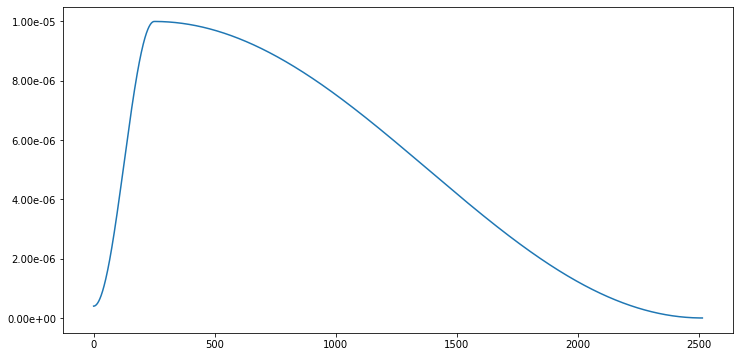

In [69]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.rcParams['figure.figsize'] = [12, 6]

iter = []
learning_rates = []
for i in range(nr_epochs * len(train_loader)):
    optimizer.step()
    learning_rates.append(learning_rate_scheduler.get_last_lr())
    iter.append(i)
    learning_rate_scheduler.step()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(iter, learning_rates)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))

## Training/finetuning


Currently all parameters in the BERT model going to be trained. The `boolean` `param.requires_grad` indicates if the weight should be trained (`True`) or if it is freezed (`False`). Hence we can list the parameters to train as follows.

In [70]:
# List parameters to train
for name, param in model.named_parameters(): 
  if param.requires_grad: 
    print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

As a first step we will only train the classification head, that is the bert.pooler layer and the classifier.

In [71]:
# We now just set some parameters to be trained
for param in model.parameters():
    param.requires_grad = False

model.bert.pooler.dense.weight.requires_grad = True
model.bert.pooler.dense.bias.requires_grad = True
model.classifier.weight.requires_grad = True
model.classifier.bias.requires_grad = True

# List parameters to train
for name, param in model.named_parameters(): 
  if param.requires_grad: 
    print(name)


bert.pooler.dense.weight
bert.pooler.dense.bias
classifier.weight
classifier.bias



Now to the actual training of the model. Our approach will be to write a standard Pytorch training loop, where we iterate over the epochs and batches with `for` loops. The general structure for such a training loop is as follows:

```python
nr_epochs = 4

for epoch in range(nr_epochs):
  for i, batch in enumerate(train_loader):
    # We set the gradients to zero
    optim.zero_grad() 

    # Extract the input_ids, attention_mask and labels.
    # Make sure they are on the right device before being passed to model.
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    # Compute the loss
    outputs = model(input_ids, attention_mask=attention_mask)
    loss = loss_function(outputs["logits"], labels)

    loss.backward() # Gradient update step, backward pass
    optim.step() # Optimizer update step
    scheduler.step() # Scheduler update step
```

Since we stepped through our optimizer and scheduler above, we need to reinstantiate them once again:

In [72]:
# The total number of epochs
nr_epochs=1

# The optimizer we are going to use
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# The loss function
loss_function = torch.nn.CrossEntropyLoss()

# The learning rate scheduler
learning_rate_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optim,
    max_lr=1e-5,
    epochs=nr_epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.1
)

Why would we prefer writing our own training loop as opposed to just using some framework providing cushy high level abstractions? As we'll see soon, the benefit is mainly that you have the freedom to customize, adapt and debug your code very easily and freely. 

* **Customization**: You don't need to understand the ins and outs of a framework, nor inspect its source code to implement, adapt and change things. 
* **Debugging**: Every parameter, every loss, every optimizer state, every scheduler state, every input and every output is available and easily inspectable for you. These things are generally hidden away from you when using higher level frameworks. 

For our actual training loop, we will add a few things. 

1. At certain intervals of iterations we would like to print our average loss during that interval. 
2. Every epoch we would like to print our accuracy, a confusion matrix, and some other useful metrics. 

In order to be fully transparent, I should state that in a typical work flow,  generally the training loop is developed first without having prediction code in place. Generally the process will include training the model for a while without doing evaluations and predictions (only tracking loss). At this stage is where the partly trained -- and unfinished -- model is used to write a proper prediction function with evaluation measures. This step is generally easier and less error prone to code once the model starts making predictions that are somewhat sensible. 

In this tutorial I will provide a prediction function immediately, but keep in mind that the figuring out of how to do basic prediction generally comes *after* having a model that no longer outputs random jibberish. 

In [73]:
from tqdm import tqdm
def predict(model, df_valid):
    probs_list = []

    # Ensure model is in eval mode before predicting (this ignores dropout layers)
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(tqdm(valid_loader)):
            # .squeeze(dim=1) changes dims [16, 1, 512] ---> [16, 512]
            input_ids = batch["input_ids"].to(device).squeeze(dim=1)
            attention_mask = batch["attention_mask"].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)

            probs_list += torch.nn.functional.softmax(outputs["logits"], dim=1)

        preds = [torch.argmax(probs, dim=0).to("cpu") for probs in probs_list]
        df_valid["preds"] = [int(pred) for pred in preds]
        df_valid["probs"] = [probs.to("cpu").tolist() for probs in probs_list]

    return df_valid


### Train the classification head (takes approx 8 minutes)

One devious thing we have to look out for is that models expect input of a certain dimensionality. Sometimes the output of our dataset/dataloader might not conform to these expectations. In our case the dimensionality of a batch of `input_ids` comes out as $16\times1\times512$. We can think of it as $16$ observations of $1\times512$ matrices. However, the row dimension $1$ of those matrices is redundant here. We might as well think of it as $16$ observations of $512$-length vectors. The model in fact expects a dimensionality of `(batch_size, input_length)` for each batch. 

A common operation for making this redundant $1$-dimensions disappear in Pytorch is the `.squeeze()` operation. Conversely, if we want to insert one of these dimensions (because a model for some reason expects it), we can use `.unsqueeze()`. 

In the code below you will see `batch["input_ids"].to(device).squeeze(dim=1)`, where we transform `input_ids` from $16\times1\times512$ to $16\times512$. The argument `dim` here refers to along which of the 3 axes `(batch_size, dummy_row, input_length)`: $16$, $1$ or $512$ that we want to perform the squeeze operation. The dimension axes start counting from $0$ (with $0$ being the `batch_size` dimension). 



In [74]:
from sklearn import metrics
loss_logger = []
iter_before_print = 50 # Iterations before printing avg loss

for epoch in range(nr_epochs):
    print(f"epoch: {epoch + 1} started")
    running_loss = 0

    for i, batch in enumerate(tqdm(train_loader)):
        optim.zero_grad()

        # .squeeze(dim=1) changes dims [16, 1, 512] ---> [16, 512]
        input_ids = batch["input_ids"].to(device).squeeze(dim=1)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_function(outputs["logits"], labels)
        
        # Collect losses to print running avg, and later plotting
        running_loss += loss.item()
        if i % iter_before_print == (iter_before_print - 1):
            print(
                (
                f" iter: {i+1}, loss: {running_loss/iter_before_print:.8f}, "
                f"lr: {learning_rate_scheduler.get_last_lr()}"
                )
            )
            loss_logger.append({"iter": i + 1, 
                                "loss": running_loss / iter_before_print})
            running_loss = 0

        # Updates of gradients and learning rate
        loss.backward()
        optimizer.step()
        learning_rate_scheduler.step()

    # Prediction and evaluation metrics
    df_res = predict(model=model, df_valid=df_valid)
    accuracy = sum(df_res["label"] == df_res["preds"]) / len(df_res)
    print(f"Accuracy: {accuracy}")
    print(
        (
            f"\033[94m Confusion Matrix: \033[0m \n" # Blue colored text
            f"{pd.crosstab(df_res['label'], df_res['preds'], margins=True)}"
        )
    )
    print(metrics.classification_report(y_true=df_res["label"], 
                                        y_pred=df_res["preds"], 
                                        labels=list(label_mapping.values()),
                                        target_names=label_mapping.keys(),
                                        zero_division=0))

epoch: 1 started


  8%|▊         | 50/629 [00:31<06:21,  1.52it/s]

 iter: 50, loss: 2.03587908, lr: [9.007478022428104e-06]


 16%|█▌        | 100/629 [01:03<05:27,  1.62it/s]

 iter: 100, loss: 1.69961977, lr: [9.894399774299177e-06]


 24%|██▍       | 150/629 [01:33<04:55,  1.62it/s]

 iter: 150, loss: 1.68100195, lr: [9.427183223268402e-06]


 32%|███▏      | 200/629 [02:05<04:30,  1.59it/s]

 iter: 200, loss: 1.73729779, lr: [8.621285772655825e-06]


 40%|███▉      | 250/629 [02:36<03:54,  1.62it/s]

 iter: 250, loss: 1.66303688, lr: [7.538359107700797e-06]


 48%|████▊     | 300/629 [03:07<03:25,  1.60it/s]

 iter: 300, loss: 1.67203734, lr: [6.261247830820594e-06]


 56%|█████▌    | 350/629 [03:39<02:55,  1.59it/s]

 iter: 350, loss: 1.60067401, lr: [4.887651795015111e-06]


 64%|██████▎   | 400/629 [04:10<02:23,  1.60it/s]

 iter: 400, loss: 1.55303254, lr: [3.522652000827434e-06]


 72%|███████▏  | 450/629 [04:41<01:52,  1.60it/s]

 iter: 450, loss: 1.50652671, lr: [2.2706718306606965e-06]


 79%|███████▉  | 500/629 [05:12<01:20,  1.60it/s]

 iter: 500, loss: 1.54695426, lr: [1.2274885913153488e-06]


 87%|████████▋ | 550/629 [05:44<00:49,  1.61it/s]

 iter: 550, loss: 1.57604424, lr: [4.7290648699900133e-07]


 95%|█████████▌| 600/629 [06:15<00:18,  1.60it/s]

 iter: 600, loss: 1.53342501, lr: [6.465154519466958e-08]


100%|██████████| 111/111 [01:06<00:00,  1.68it/s]


Accuracy: 0.4580281690140845
 Confusion Matrix:  
preds   1   3     5    7   All
label                         
0       0   0     0    1     1
1      48  14   273   48   383
2      12   4    35    8    59
3       5  16   139   28   188
4       4   2    47   15    68
5      14  16   636   78   744
6       1   2    50   23    76
7       2   2   132  113   249
8       0   0     4    3     7
All    86  56  1316  317  1775
              precision    recall  f1-score   support

           V       0.00      0.00      0.00         1
           S       0.56      0.13      0.20       383
          MP       0.00      0.00      0.00        59
           C       0.29      0.09      0.13       188
           L       0.00      0.00      0.00        68
           M       0.48      0.85      0.62       744
          KD       0.00      0.00      0.00        76
          SD       0.36      0.45      0.40       249
 independent       0.00      0.00      0.00         7

    accuracy                        

## Evaluation

How did the model perform on our evaluation dataset? It seems the model managed to to predict the correct party for roughly $46\%$ of the parliamentary motions correctly. Although the data is unbalanced and the macro average indicate that we can improve. 

In [75]:
print(
    metrics.classification_report(
        df_res["label"], 
        df_res["preds"], 
        labels=list(label_mapping.values()), 
        target_names=label_mapping.keys(),
        zero_division=0
    )
)

              precision    recall  f1-score   support

           V       0.00      0.00      0.00         1
           S       0.56      0.13      0.20       383
          MP       0.00      0.00      0.00        59
           C       0.29      0.09      0.13       188
           L       0.00      0.00      0.00        68
           M       0.48      0.85      0.62       744
          KD       0.00      0.00      0.00        76
          SD       0.36      0.45      0.40       249
 independent       0.00      0.00      0.00         7

    accuracy                           0.46      1775
   macro avg       0.19      0.17      0.15      1775
weighted avg       0.40      0.46      0.37      1775



test

### Test our model on recent parliamentary motions

We can test our model on texts from recently submitted parliamentary motions, which are neither part of the train nor the validation set. 

In [80]:
# Parliamentary motion from Miljöpartiet: https://www.riksdagen.se/sv/dokument-lagar/dokument/motion/stoppa-handeln-med-utrotningshotade-djur_HA022280
motions_text = """
Handeln med hotade arter är världens fjärde största illegala handel, och omsätter ofantliga summor som göder kriminella nätverk. 
Forskare har länge varnat om att allt fler virus riskerar att spridas från djur till människor. 
Utbrottet av Coronaviruset Covid-19 har återigen satt strålkastarljuset på kopplingen mellan djurmarknader och sjukdomar. 
En anledning till att risken för virusspridning ökar på marknaderna är att det är ohygieniska förhållanden med en stor blandning av olika djurarter, ofta stressade – som aldrig skulle träffas naturligt i det vilda. Olika virus kan då hoppa från en djurart till en annan och sedan vidare till människan. 
På den internationella marknaden säljs varje år flera miljoner vildfångade fåglar, tiotusentals apor och ett oräkneligt antal andra djur och växter år på den internationella marknaden. Djuren säljs som exotiska husdjur, eller så används deras pälsar och skin inom klädindustrin. 
Delar från skelett, horn och betar används som ingredienser i naturmediciner och mat, till smycken och prydnadsföremål. Den stora efterfrågan på elfenben bidrar till allt för stor jakt på världens elefanter. Även världens noshörningsarter hotas av tjuvjakt och illegal handel.
"""

with torch.no_grad():
    inputs = tokenizer(
        motions_text, padding="max_length", max_length=512, truncation=True, return_tensors="pt",
    )

    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    outputs = model(input_ids, attention_mask=attention_mask)

    probs = torch.nn.functional.softmax(outputs["logits"], dim=1)
    preds = torch.argmax(probs).to("cpu")

print(probs)
print(preds)

tensor([[6.4263e-05, 2.0303e-01, 3.4401e-02, 7.1131e-02, 9.6352e-02, 4.3302e-01,
         2.0872e-02, 1.4104e-01, 9.7988e-05]], device='cuda:0')
tensor(5)


## Authors

* Faton Rekathati (faton.rekathati@kb.se)
* Måns Magnusson (mans.magnusson@statistik.uu.se)
